In [2]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np

from training.losses import *
from training.train import *
from models.gan import *
from models.classifier import *

import matplotlib.pyplot as plt
from PIL import Image
from importlib import reload
%matplotlib inline

In [2]:
BATCH_SIZE = 128
LR = 3e-4
BETAS = 0.9, 0.999
LAMBDA = 0.5
DEVICE = 'cpu'

In [3]:
train_data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=True, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0).to(dtype=torch.float32))
valid_data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=False, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0).to(dtype=torch.float32))

In [4]:
base_classifier = SimpleClassifier()

base_classifier_runner = dl.SupervisedRunner(
    input_key="features", output_key="logits", target_key="targets", loss_key="loss"
)

base_classifier_runner.train(
    model=base_classifier,
    criterion= torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(base_classifier.parameters(), lr=LR, betas=BETAS),
    loaders= {
        "train": torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True),
        'valid': torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, drop_last=True)
    },
    logdir="./base_classifier_logdir",
    num_epochs=3,
    valid_loader="valid",
    valid_metric="accuracy03",
    minimize_valid_metric=False,
    verbose=True,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", num_classes=10)
    ],
)

c:\users\seray\appdata\local\programs\python\python37\lib\site-packages\catalyst\core\runner.py:567: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for k, v in self.batch_metrics.items()



train (1/3) accuracy: 0.8956330418586731 | accuracy/std: 0.11607456344011473 | accuracy01: 0.8956330418586731 | accuracy01/std: 0.11607456344011473 | accuracy03: 0.966980516910553 | accuracy03/std: 0.07149214263270973 | accuracy05: 0.9852931499481201 | accuracy05/std: 0.04307753482889212 | loss: 0.6201481819152832 | loss/mean: 0.6201481819152832 | loss/std: 0.4343929985502416 | lr: 0.0003 | momentum: 0.9



valid (1/3) accuracy: 0.9588341116905212 | accuracy/std: 0.03146800092685063 | accuracy01: 0.9588341116905212 | accuracy01/std: 0.03146800092685063 | accuracy03: 0.9934895634651184 | accuracy03/std: 0.009143613689777726 | accuracy05: 0.9976963400840759 | accuracy05/std: 0.004862918258791045 | loss: 0.2397996038198471 | loss/mean: 0.2397996038198471 | loss/std: 0.10037992334391968 | lr: 0.0003 | momentum: 0.9
* Epoch (1/3) 



train (2/3) accuracy: 0.9635416865348816 | accuracy/std: 0.01989200304274311 | accuracy01: 0.9635416865348816 | accuracy01/std: 0.01989200304274311 | accuracy03: 0.9951255321502686 | accuracy03/std: 0.006812099822121239 | accuracy05: 0.9989817142486572 | accuracy05/std: 0.0029126716323828288 | loss: 0.17221198976039886 | loss/mean: 0.17221198976039886 | loss/std: 0.058793091033871744 | lr: 0.0003 | momentum: 0.9



valid (2/3) accuracy: 0.969651460647583 | accuracy/std: 0.025669097886755213 | accuracy01: 0.969651460647583 | accuracy01/std: 0.025669097886755213 | accuracy03: 0.9966946840286255 | accuracy03/std: 0.006681106292007916 | accuracy05: 0.9989984035491943 | accuracy05/std: 0.002896145102004662 | loss: 0.13534925878047943 | loss/mean: 0.13534925878047943 | loss/std: 0.07273122706091455 | lr: 0.0003 | momentum: 0.9
* Epoch (2/3) 



train (3/3) accuracy: 0.9727063179016113 | accuracy/std: 0.0162831102724005 | accuracy01: 0.9727063179016113 | accuracy01/std: 0.0162831102724005 | accuracy03: 0.9971955418586731 | accuracy03/std: 0.0048139884345121155 | accuracy05: 0.9995158910751343 | accuracy05/std: 0.002017292365067811 | loss: 0.1105828806757927 | loss/mean: 0.1105828806757927 | loss/std: 0.040915594154247045 | lr: 0.0003 | momentum: 0.9



valid (3/3) accuracy: 0.9691506624221802 | accuracy/std: 0.02529802812425509 | accuracy01: 0.9691506624221802 | accuracy01/std: 0.02529802812425509 | accuracy03: 0.996995210647583 | accuracy03/std: 0.005898705617388444 | accuracy05: 0.9993990659713745 | accuracy05/std: 0.0027321443810467178 | loss: 0.11183144152164459 | loss/mean: 0.11183144152164459 | loss/std: 0.0673391910706154 | lr: 0.0003 | momentum: 0.9
* Epoch (3/3) 
Top best models:
base_classifier_logdir\checkpoints/train.3.pth	0.9970


In [7]:
adv_train_data = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, drop_last=True)

In [8]:
model = {"generator": Generator(image_size=10), 
         "discriminator": Discriminator(gp=False), 'attacked_model': base_classifier.eval()}
loss = {"generator": GeneratorLoss(BATCH_SIZE, DEVICE), #WGANGeneratorLoss(), 
             "discriminator": DiscriminatorLoss(BATCH_SIZE, DEVICE), #WGANDiscriminatorLoss(LAMBDA, DEVICE), 
             "attack": AttackLoss(),
             "hinge": HingeLoss(BATCH_SIZE, DEVICE)}
optimizer = {
    "generator": torch.optim.Adam(model['generator'].parameters(), lr=LR, betas=BETAS),
    "discriminator": torch.optim.Adam(model['discriminator'].parameters(), lr=LR, betas=BETAS),
}

In [28]:
# model['generator'].load_state_dict(torch.load('./wgan_mnist_logs/models/gen_checkpoint_10'))
# model['discriminator'].load_state_dict(torch.load('./wgan_mnist_logs/models/disc_checkpoint_10'))

<All keys matched successfully>

In [9]:
trainer = CustomTrainer(model,
                        optimizer,
                        loss,
                        DEVICE,
                        log_path='./dcgan_mnist_logs',
                        image_path='./img_10.jpg',
                        penalty=False)

[WinError 3] The system cannot find the path specified: './dcgan_mnist_logs'


In [10]:
res = trainer.train(adv_train_data, 10)

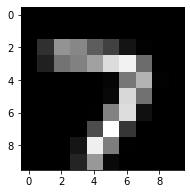

In [31]:
test_img = val_batch[0].float()[17:18]
true_confs = F.softmax(model['attacked_model'](test_img), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(model['attacked_model'](model['generator'](test_img)[0]), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
plt.imshow(test_img[0, 0] * 127.5 + 127.5, cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
plt.imshow((model['generator'](test_img)[0].cpu().detach().numpy())[0,  0] * 127.5 + 127.5, cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

In [17]:
score = 0
num = 0
for batch in torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True):
    test_img, label = batch
    test_img = test_img.float()
    true_confs = label #F.softmax(model['attacked_model'](test_img), -1).cpu().detach().numpy()
    fake_confs = F.softmax(model['attacked_model'](model['generator'](test_img)[0]), -1).cpu().detach().numpy()
    num += (np.array(label) != np.argmax(fake_confs,axis=1)).shape[0]
#     (np.argmax(true_confs, axis=1) != np.argmax(fake_confs,axis=1)).shape[0]
    score += (np.array(label) != np.argmax(fake_confs,axis=1)).sum()
#     (np.argmax(true_confs, axis=1) != np.argmax(fake_confs,axis=1)).sum()

In [18]:
score/num

0.9738414797008547

In [14]:
rs = pd.read_csv('./wgan_mnist_logs/metrics.csv')
rs

,generator_loss,discriminator_loss,attack_loss,hinge_loss,epoch,batch
0,-0.504125,0.498803,-1.482226,2.514850,0,0
1,-0.506887,0.496874,-1.717063,2.529800,0,1
2,-0.510045,0.494743,-1.865778,2.505977,0,2
3,-0.513965,0.492265,-1.704498,2.501043,0,3
4,-0.518624,0.489211,-1.547077,2.501428,0,4
...,...,...,...,...,...,...
1555,-0.991192,-0.874968,-2.814166,2.449738,19,73
1556,-0.986609,-0.863601,-2.673683,2.452317,19,74
1557,-0.975491,-0.893588,-2.720708,2.451010,19,75
1558,-0.941643,-0.902926,-2.820043,2.449004,19,76


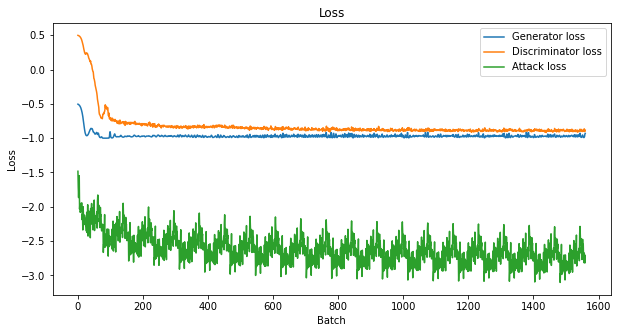

In [15]:
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(rs['generator_loss'],label="Generator loss")
plt.plot(rs['discriminator_loss'],label="Discriminator loss")
plt.plot(rs['attack_loss'],label="Attack loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()